In continuation from Notebook 1, the train and test data has to be redefined. To reduce time and space complexity, they can be loaded from the .npy files that were saved in Notebook 1.

# Import libraries

In [14]:
from sklearn import preprocessing
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.preprocessing import image # Module with image-preprocessing utilities
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19, ResNet101, ResNet152
from tensorflow.keras.callbacks import EarlyStopping

First and foremost, we load the csv files to ensure that we have the correct set of data.

In [15]:
train_df = pd.read_csv("train.csv",usecols=[1,2])
train_df

,image,label
0,fer2013/train/happy/Training_50449107.jpg,happy
1,fer2013/train/happy/Training_70433018.jpg,happy
2,fer2013/train/happy/Training_85610005.jpg,happy
3,fer2013/train/happy/Training_4460748.jpg,happy
4,fer2013/train/happy/Training_6312930.jpg,happy
...,...,...
28704,fer2013/train/disgust/Training_94788538.jpg,disgust
28705,fer2013/train/disgust/Training_81049148.jpg,disgust
28706,fer2013/train/disgust/Training_28365203.jpg,disgust
28707,fer2013/train/disgust/Training_39197750.jpg,disgust


In [16]:
test_df = pd.read_csv("test.csv",usecols=[1,2])
test_df

,image,label
0,fer2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer2013/test/happy/PublicTest_53681781.jpg,happy
3,fer2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer2013/test/happy/PublicTest_41104919.jpg,happy
...,...,...
7173,fer2013/test/disgust/PrivateTest_79683471.jpg,disgust
7174,fer2013/test/disgust/PrivateTest_34013087.jpg,disgust
7175,fer2013/test/disgust/PublicTest_67559665.jpg,disgust
7176,fer2013/test/disgust/PrivateTest_89077668.jpg,disgust


Then, we load the train and test data.

In [ ]:
x_train = np.load('x_train_data.npy')
print('x_train ', x_train.shape)
x_test = np.load('x_test_data.npy')
print('x_test ', x_test.shape)

In [7]:
y_train = np.load('y_train_data.npy')
y_test = np.load('y_test_data.npy')

We apply train_test_split to the data accordingly.

In [8]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
print(partial_X_train.shape)
print(X_val.shape)
print(partial_y_train.shape)
print(y_val.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)
(22967, 7)
(5742, 7)


Continuing from Notebook 1, hyperparameter tuning will be implemented. 

# Hyperparameter Tuning using keras tuner
There are various algorithm tuners such as Random Search and Hyperband, but in this case, Hyperband is selected as it solves the problem of Random Search which is wastage of resources. Random Search may randomly choose some values which are clearly inefficient but will still do training and validate on it. Hyperband solves this by training only for a few epochs rather than doing a full training run and then selects the best values based on the results. This cycle is repeated until it finally does a full training run and evaluate the model using the best hyperparameters.

The references adopted are as follows:

https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [25]:
def CNN_builder(hp):
    model = models.Sequential()

    # Tune the number of units in the Convolutional and Dense layers
    # Finds the optimal value between 64, 128, 256 and 512
    
    model.add(Conv2D(filters=hp.Choice('conv1_filter', values=[64, 128, 256, 512]), kernel_size=(3,3), activation='relu', input_shape=(48,48,1), 
                     kernel_regularizer=tf.keras.regularizers.L2(hp.Float('conv1_L2', min_value=0.00001, max_value=0.00015, step=0.00001))))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Choice('conv2_filter', values=[64, 128, 256, 512]), kernel_size=(3,3), activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(hp.Float('conv2_L2', min_value=0.00001, max_value=0.00015, step=0.00001))))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Choice('conv3_filter', values=[64, 128, 256, 512]), kernel_size=(3,3), activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(hp.Float('conv3_L2', min_value=0.00001, max_value=0.00015, step=0.00001))))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense1_filter', values=[64, 128, 256, 512]), activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.L2(hp.Float('dense1_L2', min_value=0.00001, max_value=0.00015, step=0.00001))))
    model.add(Dense(units=hp.Choice('dense2_filter', values=[64, 128, 256, 512]), activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.L2(hp.Float('dense2_L2', min_value=0.00001, max_value=0.00015, step=0.00001))))
    model.add(Dense(7, activation='softmax'))

    tf.random.set_seed(42)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

    return model

In [26]:
# Calling Hyperband to build our CNN model
tuner = kt.Hyperband(CNN_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     directory='cnn_tuner_directory',
                     project_name='cnn_tuner')

2022-08-12 18:11:00.476419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Prints the hyperparameters to search the optimal values for
tuner.search_space_summary()

Search space summary
Default search space size: 10
conv1_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
conv1_L2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.00015, 'step': 1e-05, 'sampling': None}
conv2_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
conv2_L2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.00015, 'step': 1e-05, 'sampling': None}
conv3_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
conv3_L2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.00015, 'step': 1e-05, 'sampling': None}
dense1_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
dense1_L2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.00015, 'step': 1e-05, 'sampling': None}
dense2_filter (

In [28]:
# Define a stop early function; stops training when validation loss stops improving for 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [29]:
# Process of searching for the optimal hyperparameters
tuner.search(partial_X_train, partial_y_train, epochs=50, validation_data=(X_val, y_val), 
             batch_size=64, callbacks=[stop_early])

Trial 90 Complete [00h 30m 46s]
val_accuracy: 0.5593869686126709

Best val_accuracy So Far: 0.5696621537208557
Total elapsed time: 5d 03h 23m 28s
INFO:tensorflow:Oracle triggered exit


In [32]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
best_hp.values

{'conv1_filter': 128,
 'conv1_L2': 0.00011,
 'conv2_filter': 256,
 'conv2_L2': 2e-05,
 'conv3_filter': 128,
 'conv3_L2': 0.00014000000000000001,
 'dense1_filter': 512,
 'dense1_L2': 8e-05,
 'dense2_filter': 256,
 'dense2_L2': 2e-05,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0035'}

From the results, some inferences could be derived. For example, the Dense layers decreased from 512 to 256. This could be to prevent overfitting. The Dense layer with 512 neurons could be high for capturing all information, while the Dense layer with a lower 256 neurons could be to prevent overfitting, as a layer with the same of higher number of neurons could start to overfit.

After obtaining the optimal hyperparameters, we first run full training on a new model (without data augmentation) using the derived values to discover the effects of data augmentation.

## Model using optimal hyperparameters (without data augmentation)
Depending on the results of hyperparameter tuning, the values of the tuned hyperparameters are used for optimization.

In [35]:
model = models.Sequential()

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1), 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00011)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00002)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00014)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00008)))
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00002)))
# output layer
model.add(Dense(7, activation='softmax'))

tf.random.set_seed(42)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

The number of epochs was increased to view the model training over a longer period of time and determine the optimal number of epochs.

In [37]:
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    batch_size=64, 
                    epochs=50, 
                    validation_data=(X_val, y_val))

Epoch 1/50
359/359 [==============================] - 159s 441ms/step - loss: 1.7910 - accuracy: 0.2777 - val_loss: 1.6142 - val_accuracy: 0.3767
Epoch 2/50
359/359 [==============================] - 170s 474ms/step - loss: 1.5011 - accuracy: 0.4216 - val_loss: 1.3907 - val_accuracy: 0.4645
Epoch 3/50
359/359 [==============================] - 187s 520ms/step - loss: 1.3424 - accuracy: 0.4917 - val_loss: 1.2857 - val_accuracy: 0.5167
Epoch 4/50
359/359 [==============================] - 196s 547ms/step - loss: 1.2551 - accuracy: 0.5305 - val_loss: 1.2680 - val_accuracy: 0.5206
Epoch 5/50
359/359 [==============================] - 203s 567ms/step - loss: 1.1869 - accuracy: 0.5608 - val_loss: 1.2354 - val_accuracy: 0.5442
Epoch 6/50
359/359 [==============================] - 207s 577ms/step - loss: 1.1285 - accuracy: 0.5851 - val_loss: 1.2335 - val_accuracy: 0.5515
Epoch 7/50
359/359 [==============================] - 208s 581ms/step - loss: 1.0725 - accuracy: 0.6081 - val_loss: 1.2154 -

In [38]:
tuner_history = history.history

In [39]:
# Define plotting of the accuracy graph for efficiency
def plot_graph(history):
    plt.plot(history['accuracy'], label="Train Accuracy") # blue 
    plt.plot(history['val_accuracy'], label="Validation Accuracy") # orange
    plt.legend()
    plt.title('Accuracy Graph')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.show()

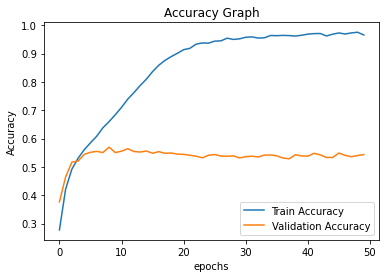

In [40]:
plot_graph(tuner_history)

In [41]:
test_loss, test_acc = model.evaluate(x_test, y_test)

225/225 [==============================] - 10s 45ms/step - loss: 4.1506 - accuracy: 0.5424


From the results above, the model achieved 96% training accuracy and 54% testing accuracy. Evidently, overfitting occurred as seen from the accuracy scores and by analysing the graph. Next, we define the same model but this time with data augmentation. 

## Model using optimal hyperparameters (with data augmentation)
The model is first built.

In [42]:
model = models.Sequential()

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1), 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00011)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00002)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.00014)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00008)))
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00002)))
# output layer
model.add(Dense(7, activation='softmax'))

tf.random.set_seed(42)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [43]:
# Setting up an image data augmentation configuration 
# using ImageDataGenerator which augments the images based on the features specified
train_imagegen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [44]:
# fit the image data generator to the training data
train_imagegen.fit(x_train)

In [45]:
# Generated batches of augmented data that are separated into partial and validation datasets
ptrain_image_generators = train_imagegen.flow(partial_X_train, partial_y_train)
val_image_generators = train_imagegen.flow(X_val, y_val)

In [47]:
# fits the model on the predefined batches with real-time data augmentation
data_aug_history = model.fit(ptrain_image_generators,
                             validation_data=val_image_generators,
                             epochs=50, batch_size=64)

Epoch 1/50
718/718 [==============================] - 148s 206ms/step - loss: 1.8196 - accuracy: 0.2545 - val_loss: 1.7820 - val_accuracy: 0.2558
Epoch 2/50
718/718 [==============================] - 172s 240ms/step - loss: 1.7581 - accuracy: 0.2745 - val_loss: 1.7407 - val_accuracy: 0.2692
Epoch 3/50
718/718 [==============================] - 175s 244ms/step - loss: 1.7216 - accuracy: 0.2999 - val_loss: 1.6863 - val_accuracy: 0.3224
Epoch 4/50
718/718 [==============================] - 180s 250ms/step - loss: 1.6664 - accuracy: 0.3391 - val_loss: 1.6457 - val_accuracy: 0.3504
Epoch 5/50
718/718 [==============================] - 182s 254ms/step - loss: 1.6095 - accuracy: 0.3728 - val_loss: 1.5874 - val_accuracy: 0.3856
Epoch 6/50
718/718 [==============================] - 183s 255ms/step - loss: 1.5663 - accuracy: 0.3952 - val_loss: 1.5897 - val_accuracy: 0.3777
Epoch 7/50
718/718 [==============================] - 187s 260ms/step - loss: 1.5283 - accuracy: 0.4151 - val_loss: 1.5141 -

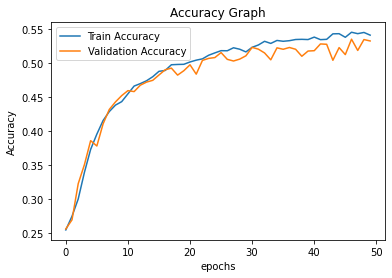

In [48]:
plot_graph(data_aug_history.history)

In [49]:
model.save('data_aug.h5')
model = load_model('data_aug.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

In [50]:
test_loss, test_acc = model.evaluate(x_test, y_test)

225/225 [==============================] - 11s 45ms/step - loss: 1.1981 - accuracy: 0.5708


The model that uses data augmentation achieved 54% training accuracy and 57% testing accuracy. 
Comparing the models with and without augmentation, it is clear that the model without data augmentation has significantly higher training accuracy. However, it has lower testing accuracy. Additionally, it is clear that it has low generalizability as it stops improving after around epoch 8. Thus, we can conclude that the model with data augmentation improves the generalizability of the model and thus a higher test accuracy as the model is able to apply the knowledge from its training to an unseen task.

Next, we proceed with transfer learning which trains the dataset on tensorflow keras' pretrained convnets. Continuation of the process flow can be found in Notebook 3.

## View the augmented images
Code was adapted from Deep Learning with Python (Chollet, 2018)

fer2013/train/surprise/Training_16433189.jpg


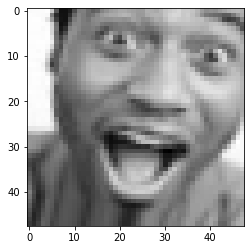

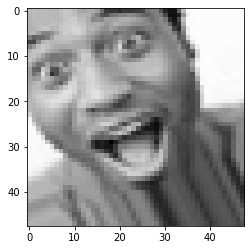

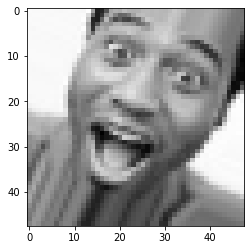

In [51]:
random_number = random.randint(0, len(train_df))
# Chooses one random image from train dataset to augment
img_path = train_df['image'][random_number]
print(img_path)
img = image.load_img(img_path) # Reads the image 

x = image.img_to_array(img) # Converts to a Numpy array with shape (48, 48, 3)
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 48, 48, 3)

# Generates batches of randomly transformed images. An infinite loop, so need to break it
l = 0
for batch in train_imagegen.flow(x, batch_size=1):
    plt.figure(l)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    l += 1
    if l == 3:
        break
plt.show()

# Reference 

1. (Chollet, 2018)

Chollet, F., 2018. Deep Learning with Python. USA: Manning Publications Co., p.139-140.